<a href="https://colab.research.google.com/github/mtlmh34/AML_Project/blob/main/grp%20proj1.11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving fake_job_postings.csv to fake_job_postings (1).csv


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model, tree, model_selection, ensemble, svm, metrics, naive_bayes
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df=pd.read_csv('fake_job_postings.csv')

In [ ]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [ ]:
# drop columns with more than 50% missing data
df.drop(columns=['department', 'salary_range', 'industry'], inplace = True)

In [ ]:
#-------------------start cleaning for location column

#--------1. split the columns to country, state, and city

# to use country only?
df['country']=df.location.str.split(',',expand=True)[:][0]

df['state']=df.location.str.split(',',expand=True)[:][1]
df['city']=df.location.str.split(',',expand=True)[:][2]

#----------2. replacing different kinds of missing value to np.nan
df.state = df.state.str.strip()
df.state.fillna(value=np.nan, inplace=True)
df.state.replace('', np.nan, inplace=True)
df.state.replace(' ', np.nan, inplace=True)


#df['state'].sort_values().unique()

#----------3. clear the whitespaces and signs at the start/end

df.city = df.city.str.strip(' /:\\')

#---------4. replacing different kinds of missing value to np.nan
df.city.fillna(value=np.nan, inplace=True)
df.city.replace('', np.nan, inplace=True)
df.city.replace(' ', np.nan, inplace=True)
df['city']=df.city.str.lower()
#------

# drop unnecessary columns
df.drop(['location'], axis = 1, inplace = True)

# too many empty fields in city, hence dropped
df.drop(columns=['city'], axis=1, inplace = True)

In [ ]:
#-------------------start cleaning for text columns

def preprocess_text(text):
    
    
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\b[A-Za-z]+\b')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords


df['text'] = df.apply(lambda row: (str(row['title']) + ' ' + 
                                   str(row['company_profile']) + ' ' + 
                                   str(row['description']) + ' ' + 
                                   str(row['requirements']) + ' ' + 
                                   str(row['benefits'])), axis = 1)

# Fill empty columns with "Unspecified"
df['text'] = df['text'].fillna("Unspecified")
    
# Create an instance of TfidfVectorizer
vectoriser = TfidfVectorizer(analyzer=preprocess_text, ngram_range = (1,2),   #TRY ADJUSTING ngram_range and min_df, max_df
                                min_df= 0.01, max_df= 0.7)

# Fit to the data and transform to feature matrix
text_column = vectoriser.fit_transform(df['text'])

# Convert sparse matrix to dataframe
text_column = pd.DataFrame.sparse.from_spmatrix(text_column)

# Save mapping on which index refers to which words
col_map = {v:k for k, v in vectoriser.vocabulary_.items()}

# Rename each column using the mapping
for col in text_column.columns:
    text_column.rename(columns={col: col_map[col]}, inplace=True)

In [ ]:
#-------------------continue cleaning for text columns

# identify which text feature is not populated before dropping them
columns_to_remove = ['requirements', 'company_profile', 'description', 'benefits', 'title', 'text']

for i in columns_to_remove:
  df[i] = df[i].fillna("unspecified")

# create new binary columns to check if features are provided in the job ad
new_columns = ['has_requirements', 'has_company_profile', 'has_description', 'has_benefits']

for i in range(len(new_columns)):
  df[new_columns[i]] = df[columns_to_remove[i]].apply(lambda x: 0 if x == "unspecified" else 1)

df.drop(columns = columns_to_remove, axis = 1, inplace = True)
df.drop(columns = ['job_id'], axis = 1, inplace = True)

In [ ]:
#-------------------cleaning categorical columns 
category_columns = ['employment_type', 'required_experience', 'required_education', 'function', 'country', 'state']

for i in category_columns:
  df[i] = df[i].fillna(i + "_unspecified")

categorical_features = pd.concat([pd.get_dummies(df['employment_type']), 
                                  pd.get_dummies(df['required_experience']), 
                                  pd.get_dummies(df['required_education']), 
                                  pd.get_dummies(df['country']),
                                  pd.get_dummies(df['state'])])

df.drop(columns = category_columns, axis = 1, inplace = True)

In [ ]:
# combine vectorised columns and sparse categorical columns to the main df
df = pd.concat([df, text_column], axis =1, ignore_index=False)

In [ ]:
X_data = df.drop(columns = 'fraudulent', axis = 1)
y_data = df['fraudulent']

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42, sampling_strategy=0.4)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_resample, y_resampled = smt.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [ ]:
clf = ensemble.RandomForestClassifier(random_state=42)
clf.fit(X_resample, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


RandomForestClassifier(random_state=42)

In [ ]:
y_pred_train = clf.predict(X_resample)
y_pred_prob_train = clf.predict_proba(X_resample)[:,1]
    
precision_train = metrics.precision_score(y_resampled, y_pred_train)
recall_train = metrics.recall_score(y_resampled, y_pred_train)
f1_train = metrics.f1_score(y_resampled, y_pred_train)
roc_auc_train = metrics.roc_auc_score(y_resampled, y_pred_prob_train)

precision_train, recall_train, f1_train, roc_auc_train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(1.0, 1.0, 1.0, 1.0)

In [ ]:
y_pred_test = clf.predict(X_test)
y_pred_prob_test = clf.predict_proba(X_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(1.0, 0.6187845303867403, 0.7645051194539249, 0.9877769550606595)

In [ ]:
rf = {'Feature': clf.feature_names_in_, 'Importance': clf.feature_importances_}
df_rf = pd.DataFrame(rf)
df_rf = df_rf.sort_values(by = 'Importance', key = abs, ascending = False, ignore_index =True)
df_rf.head(10)

,Feature,Importance
0,has_company_logo,0.036117
1,has_company_profile,0.030755
2,nan,0.021251
3,earn,0.020401
4,administrative,0.009281
5,clerk,0.008873
6,follow,0.008391
7,per,0.008291
8,clerical,0.007495
9,gas,0.006956


In [ ]:
def model_build(base_estimator, parameters):
    
    clf = model_selection.RandomizedSearchCV(
        base_estimator, 
        parameters, 
        scoring = 'recall')
    
    clf.fit(X_resample, y_resampled)
    
    print('best score:', clf.best_score_)
    print('best parameters: ', clf.best_params_)

    optimised = clf.best_estimator_
    return optimised

In [ ]:
random_grid = {'n_estimators': [x for x in np.arange(start=80,stop=200,step=10)],
               'criterion': ['gini', 'entropy'], 
               'min_samples_leaf': [1,2,3,4,5],
               'min_samples_split': [2,3,4,5]}

optimised_rf = model_build(ensemble.RandomForestClassifier(random_state=2022), random_grid)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse co

best score: 0.9812803598958728
best parameters:  {'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini'}


In [ ]:
rf = {'Feature': optimised_rf.feature_names_in_, 'Importance': optimised_rf.feature_importances_}
df_rf = pd.DataFrame(rf)
df_rf = df_rf.sort_values(by = 'Importance', ascending = False, ignore_index =True)
df_rf.head(10)

,Feature,Importance
0,has_company_profile,0.041066
1,has_company_logo,0.038099
2,nan,0.019175
3,earn,0.014921
4,oil,0.011162
5,per,0.010413
6,entry,0.009335
7,schedule,0.007972
8,clerk,0.007865
9,administrative,0.007640


In [ ]:
y_pred_train = optimised_rf.predict(X_resample)
y_pred_prob_train = optimised_rf.predict_proba(X_resample)[:,1]
    
precision_train = metrics.precision_score(y_resampled, y_pred_train)
recall_train = metrics.recall_score(y_resampled, y_pred_train)
f1_train = metrics.f1_score(y_resampled, y_pred_train)
roc_auc_train = metrics.roc_auc_score(y_resampled, y_pred_prob_train)

precision_train, recall_train, f1_train, roc_auc_train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(1.0, 0.9996328254084818, 0.999816378993757, 1.0)

In [ ]:
y_pred_test = optimised_rf.predict(X_test)
y_pred_prob_test = optimised_rf.predict_proba(X_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.9823008849557522,
 0.6132596685082873,
 0.7551020408163266,
 0.9872521338660201)

In [ ]:
optimised_rf

RandomForestClassifier(min_samples_split=5, n_estimators=80, random_state=2022)

In [ ]:
rf_matrix = metrics.confusion_matrix(y_resampled, y_pred_train, labels=[1,0])
rf_matrixt = metrics.confusion_matrix(y_test, y_pred_test, labels=[1,0])

report = """
Confusion Matrix for train dataset:
{}
Confusion Matrix for test dataset:
{}
""".format(rf_matrix, rf_matrixt)
print(report)


Confusion Matrix for train dataset:
[[ 5445     2]
 [    0 13619]]
Confusion Matrix for test dataset:
[[ 111   70]
 [   2 3393]]



In [ ]:
df[df['fraudulent']==0]['has_company_profile'].value_counts(normalize=True)

1    0.840073
0    0.159927
Name: has_company_profile, dtype: float64

In [ ]:
#---------------------------------- build Naive Bayes Model

In [ ]:
mnb = naive_bayes.MultinomialNB()
mnb.fit(X_resample, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


MultinomialNB()

In [ ]:
y_pred_train = mnb.predict(X_resample)
y_pred_prob_train = mnb.predict_proba(X_resample)[:,1]
    
precision_train = metrics.precision_score(y_resampled, y_pred_train)
recall_train = metrics.recall_score(y_resampled, y_pred_train)
f1_train = metrics.f1_score(y_resampled, y_pred_train)
roc_auc_train = metrics.roc_auc_score(y_resampled, y_pred_prob_train)

precision_train, recall_train, f1_train, roc_auc_train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.8874133949191686, 0.8465210207453644, 0.8664850136239781, 0.976494733077431)

In [ ]:
y_pred_test = mnb.predict(X_test)
y_pred_prob_test = mnb.predict_proba(X_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.446875, 0.7900552486187845, 0.5708582834331337, 0.9583641852252662)

In [ ]:
cf_matrixtr = metrics.confusion_matrix(y_resampled, y_pred_train, labels=[1,0])
cf_matrixte = metrics.confusion_matrix(y_test, y_pred_test, labels=[1,0])

report = """
Confusion Matrix for train dataset:
{}
Confusion Matrix for test dataset:
{}
""".format(cf_matrixtr, cf_matrixte)
print(report)


Confusion Matrix for train dataset:
[[ 4611   836]
 [  585 13034]]
Confusion Matrix for test dataset:
[[ 143   38]
 [ 177 3218]]



In [ ]:
# match feature names and respective feature counts in each class
f = {'Feature': X_resample.columns, 'fraud': mnb.feature_count_[1,:],
         'not_fraud': mnb.feature_count_[0,:]}
features = pd.DataFrame(data=f)

# calculate the P(feature|class) by using feature count in the class divided by respective class count
# 1 count is added to all feature counts to ensure ratio can be calculated later
features['P (f|fraud)'] = (features['fraud'] +1) / mnb.class_count_[1]
features['P (f|not_fraud)'] = (features['not_fraud'] +1) / mnb.class_count_[0]

# ratio of the P(feature|class) is used to evaluate the predictiveness of the token 
features['Ratio'] = features['P (f|fraud)'] / features['P (f|not_fraud)']

# print out the top 10 features for each class
print('The top 20 most predictive tokens for fraud job postings are:')
print(features.sort_values(by=['Ratio'], ascending= False).head(20)['Feature'].values)

print('The top 20 most predictive tokens for not fraud job postings are:')
print(features.sort_values(by=['Ratio'], ascending= False).tail(20)['Feature'].values)

The top 20 most predictive tokens for fraud job postings are:
['clerical' 'clerk' 'earn' 'entry' 'figure' 'duration' 'cash' 'oil' 'gas'
 'aptitude' 'referral' 'offshore' 'refine' 'minutes' 'recovery' 'fee'
 'suitable' 'guarantee' 'administrative' 'housekeep']
The top 20 most predictive tokens for not fraud job postings are:
['greece' 'php' 'kid' 'teachers' 'necessarycanada' 'european' 'olds'
 'interactive' 'game' 'airfare' 'teacher' 'passport' 'cardsgabriel'
 'adkins' 'reimbursedexcellent' 'celta' 'tesol' 'tefl' 'asia' 'abroad']


In [ ]:
# try naive bayes with only text columns
X_train, X_test, y_train, y_test = train_test_split(text_column, y_data, test_size=0.2, random_state=42)
X_resample, y_resampled = smt.fit_resample(X_train, y_train)
text_resample = X_resample.drop(X_resample.columns[0:8], axis = 1)
text_test = X_test.drop(X_resample.columns[0:8], axis = 1)

KeyboardInterrupt: ignored

In [ ]:
mnb2 = naive_bayes.MultinomialNB()
mnb2.fit(text_resample, y_resampled)

y_pred_train = mnb.predict(X_resample)
y_pred_prob_train = mnb.predict_proba(X_resample)[:,1]
y_pred_test = mnb2.predict(text_test)
y_pred_prob_test = mnb2.predict_proba(text_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

In [ ]:
cf_matrixtr = metrics.confusion_matrix(y_resampled, y_pred_train)
cf_matrixte = metrics.confusion_matrix(y_test, y_pred_test)

report = """
Confusion Matrix for train dataset:
{}
Confusion Matrix for test dataset:
{}
""".format(cf_matrixtr, cf_matrixte)
print(report)

In [ ]:
y_score = mnb.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [ ]:
#--------------------- gradient boosting

In [ ]:
gbt = ensemble.GradientBoostingClassifier(random_state=42)
gbt.fit(X_resample, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


GradientBoostingClassifier(random_state=42)

In [ ]:
y_pred_train = gbt.predict(X_resample)
y_pred_prob_train = gbt.predict_proba(X_resample)[:,1]
    
precision_train = metrics.precision_score(y_resampled, y_pred_train)
recall_train = metrics.recall_score(y_resampled, y_pred_train)
f1_train = metrics.f1_score(y_resampled, y_pred_train)
roc_auc_train = metrics.roc_auc_score(y_resampled, y_pred_prob_train)

precision_train, recall_train, f1_train, roc_auc_train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.9763481551561022,
 0.9473104461171287,
 0.9616101379053298,
 0.9972241638625873)

In [ ]:
y_pred_test = gbt.predict(X_test)
y_pred_prob_test = gbt.predict_proba(X_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.7247191011235955, 0.712707182320442, 0.7186629526462395, 0.9768110399596417)

In [ ]:
gbt = {'Feature': gbt.feature_names_in_, 'Importance': gbt.feature_importances_}
df_gbt = pd.DataFrame(gbt)
df_gbt = df_gbt.sort_values(by = 'Importance', key = abs, ascending = False, ignore_index =True)
df_gbt.head(10)

,Feature,Importance
0,has_company_profile,0.244985
1,has_company_logo,0.058875
2,earn,0.042011
3,maximize,0.038198
4,encourage,0.031418
5,applicable,0.028488
6,represent,0.027351
7,oil,0.023081
8,corporate,0.019519
9,schedule,0.019318


In [ ]:
gb_matrixtr = metrics.confusion_matrix(y_resampled, y_pred_train, labels=[1,0])
gb_matrixte = metrics.confusion_matrix(y_test, y_pred_test, labels=[1,0])

report = """
Confusion Matrix for train dataset:
{}
Confusion Matrix for test dataset:
{}
""".format(gb_matrixtr, gb_matrixte)
print(report)


Confusion Matrix for train dataset:
[[ 5160   287]
 [  125 13494]]
Confusion Matrix for test dataset:
[[ 129   52]
 [  49 3346]]



In [360]:
gradient_grid = {'n_estimators': [x for x in np.arange(start=80,stop=200,step=20)],
               'learning_rate': [0.001, 0.01, 0.1]}

optimised_gbt = model_build(ensemble.GradientBoostingClassifier(random_state=2022), gradient_grid)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse co

best score: 0.9504450678595798
best parameters:  {'n_estimators': 160, 'learning_rate': 0.1}


In [361]:
gbt = {'Feature': optimised_gbt.feature_names_in_, 'Importance': optimised_gbt.feature_importances_}
df_gbt = pd.DataFrame(gbt)
df_gbt = df_gbt.sort_values(by = 'Importance', ascending = False, ignore_index =True)
df_gbt.head(10)

,Feature,Importance
0,has_company_profile,0.236311
1,has_company_logo,0.056958
2,earn,0.040666
3,maximize,0.036852
4,encourage,0.030236
5,applicable,0.027559
6,represent,0.026334
7,oil,0.022395
8,corporate,0.018785
9,schedule,0.018591


In [362]:
gb_matrixtr = metrics.confusion_matrix(y_resampled, y_pred_train, labels=[1,0])
gb_matrixte = metrics.confusion_matrix(y_test, y_pred_test, labels=[1,0])

report = """
Confusion Matrix for train dataset:
{}
Confusion Matrix for test dataset:
{}
""".format(gb_matrixtr, gb_matrixte)
print(report)


Confusion Matrix for train dataset:
[[ 5445     2]
 [    0 13619]]
Confusion Matrix for test dataset:
[[ 143   38]
 [   8 3387]]



In [363]:
y_pred_test = optimised_gbt.predict(X_test)
y_pred_prob_test = optimised_gbt.predict_proba(X_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.7953216374269005,
 0.7513812154696132,
 0.7727272727272728,
 0.9816922839079244)

In [364]:
optimised_gbt

GradientBoostingClassifier(n_estimators=160, random_state=2022)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


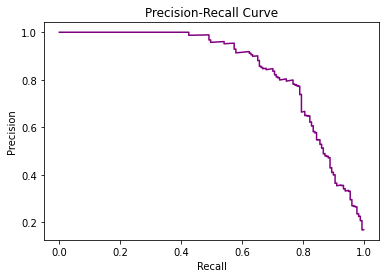

In [368]:
y_score = optimised_gbt.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [ ]:
clf_svm = svm.SVC(probability=True, random_state=42)
clf_svm.fit(X_resample, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


SVC(probability=True, random_state=42)

In [ ]:
y_pred_test = clf_svm.predict(X_test)
y_pred_prob_test = clf_svm.predict_proba(X_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.9415584415584416,
 0.8011049723756906,
 0.8656716417910447,
 0.9807663203118007)

In [ ]:
from sklearn.model_selection import GridSearchCV
def model_build2(base_estimator, parameters):
    
    clf = model_selection.GridSearchCV(
        base_estimator, 
        parameters)
    
    clf.fit(X_resample, y_resampled)
    
    print('best score:', clf.best_score_)
    print('best parameters: ', clf.best_params_)

    optimised = clf.best_estimator_
    return optimised

In [ ]:
svm_grid = {'C': [0.1, 1.0, 10]}

optimised_svm = model_build2(svm.SVC(random_state=2022, probability=True), svm_grid)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse co

best score: 0.9965383789704061
best parameters:  {'C': 10}


In [ ]:
optimised_svm = svm.SVC(random_state=2022, probability=True, C=10)

In [ ]:
optimised_svm.fit(X_resample, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


SVC(C=10, probability=True, random_state=2022)

In [ ]:
y_pred_test = optimised_svm.predict(X_test)
y_pred_prob_test = optimised_svm.predict_proba(X_test)[:,1]
    
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)

precision, recall, f1, roc_auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


(0.9470198675496688,
 0.7900552486187845,
 0.8614457831325301,
 0.9731364779208944)

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


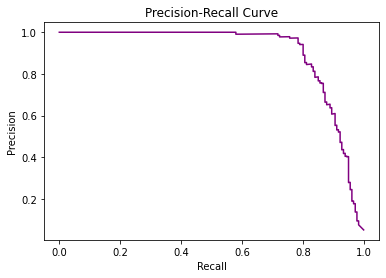

In [ ]:
y_score = optimised_svm.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()